In [2]:
from cubespecfit.fitting import fitcube_two_model
from cubespecfit.models import ha_nii_model, ha_nii_broad_model

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from astropy.io import fits

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Read in the data cube, uncertainty cube, FITS header
This example requires that the data be contained in extension 1, with the uncertainties in extension 2. The file used here is the level 3 pipeline product
for SPT2147-50, and is included in this repository.

In [3]:
file = "jw01355-o019_t005_nirspec_g395m-f290lp_s3d.fits"
hdul = fits.open(file)

cube = hdul[1].data
err_cube = hdul[2].data
header = hdul[1].header

# Determine the wavelength axis from the FITS header, set the systemic redshift
The redshift is used in determining which region of the cube contains the relevant emission lines. It does not have to be overly precise.

In [4]:
wl = np.linspace(header["CRVAL3"], header["CRVAL3"]+(header["NAXIS3"]-1)*header["CDELT3"], header["NAXIS3"])
z_sys = 3.760

# Set the model to be fit to the data, choose an initial parameter guess, define parameter bounds
This example uses the H-alpha+[NII] triple-Gaussian model. The parameters are:
- Redshift
- H-alpha integrated line flux
- Line RMS
- [NII]/H-alpha ratio
- Continuum flux

The wavelengths of the lines are fixed, and in this case their linewidths are tied to be the same (although this is
a simplistic example).
Note that the fitting code automatically normalizes the channel line fluxes by the maximum value in each slice,
and therefore the peak line flux of the model should always be approximately 1.

In [5]:
# define narrow and broad models
model_narrow = ha_nii_model
model_broad = ha_nii_broad_model

l0 = 0.65646
l = l0*(1+z_sys)

In [6]:
z_guess, z_min, z_max = z_sys, z_sys-0.004, z_sys+0.004
I_Ha_guess, I_Ha_min, I_Ha_max = 0.005, 0.002, 0.1
sig_guess, sig_min, sig_max = 130, 40, 400
NIIHa_guess, NIIHa_min, NIIHa_max = 0.2, 0, 3
c_guess, c_min, c_max = 0.5, 0.1, 1

p0_n = [z_guess, I_Ha_guess, sig_guess/3e05*l, NIIHa_guess, c_guess]
bounds_n = [[z_min, I_Ha_min, sig_min/3e05*l, NIIHa_min, c_min],
        [z_max, I_Ha_max, sig_max/3e05*l, NIIHa_max, c_max]]

In [7]:
p0_n, bounds_n

([3.76, 0.005, 0.0013540581599999998, 0.2, 0.5],
 [[3.756, 0.002, 0.00041663328, 0, 0.1],
  [3.764, 0.1, 0.004166332799999999, 3, 1]])

In [8]:
I_Ha_broad_guess = 0.002
I_Ha_broad_min = 0.0001
I_Ha_broad_max = 0.05

sig_broad_guess = 500  # km/s
sig_broad_min = 400     # conservative lower bound
sig_broad_max = 3000    # conservative upper bound

# Convert velocity dispersion to wavelength units (same as for narrow)
sig_broad_guess_um = sig_broad_guess / 3e5 * l
sig_broad_min_um = sig_broad_min / 3e5 * l
sig_broad_max_um = sig_broad_max / 3e5 * l

p0_b = p0_n + [I_Ha_broad_guess, sig_broad_guess_um]
bounds_b = [
    bounds_n[0] + [I_Ha_broad_min, sig_broad_min_um],
    bounds_n[1] + [I_Ha_broad_max, sig_broad_max_um],
]

In [9]:
p0_b, bounds_b

([3.76, 0.005, 0.0013540581599999998, 0.2, 0.5, 0.002, 0.005207916],
 [[3.756, 0.002, 0.00041663328, 0, 0.1, 0.0001, 0.004166332799999999],
  [3.764, 0.1, 0.004166332799999999, 3, 1, 0.05, 0.031247496]])

# Choose wavelength range to fit, S/N threshold for the fitting, minimum and maximum bin size
Here we use a central wavelength of 0.65646$\mu$m, i.e. H-alpha in vacuum, and fit within a region of $\pm$0.1$\mu$m. For the continuum estimate we
mask the region that is +0.02/-0.01$\mu$m of the central wavelength.
These numbers were chosen through trial and error, and the grid plots that are output after the fitting is complete show the fitting region, and 
highlight the no_line region so that the user can visually assess their decision.
A S/N of 5 is chosen to ensure that only real signal is detected (in reality the code is not perfect and sometimes it finds fits where there appears
to be no real emission - this is a work in progress), and we set 
minimum and maximum bin sizes of 1 and 3. If the detections are strong enough, these can both be set to 0.

In [15]:
dl = 7000/3e05*l
no_line = (wl < l-1500/3e05*l) | (wl > l+1500/3e05*l)

snr_cut = 5
bin_lower, bin_upper = 1, 1

# Do the fitting

In [16]:
param_cube, param_err_cube, snr_map, bin_map, norm_map, broad_map, bic_map = fitcube_two_model(cube=cube, err_cube=err_cube, wl=wl, model_narrow=model_narrow, model_broad=model_broad, z_sys=z_sys, p0_n=p0_n, p0_b=p0_b, 
                bounds_n=bounds_n, bounds_b=bounds_b, l0=l0, no_line=no_line, dl=dl, snr_cut=snr_cut, bin_lower=bin_lower, bin_upper=bin_upper, snr_max=50,
                save_grid=True, detailed_plot=False, save_to=None, ref_header=None, bic_threshold=10,
                use_rms=False)

param_cube[param_cube==0], param_err_cube[param_err_cube==0] = np.nan, np.nan       # set zero velocities to NaNs
param_cube[0,:,:] = ((1+z_sys)-(1+param_cube[0,:,:]))/(1+z_sys)*3e05                # convert redshifts to velocities
param_cube[0, :, :] = param_err_cube[0, :, :] / (1 + z_sys) * 3e05
param_cube[2,:,:] *= 3E05/(l0*(1+z_sys))                                            # convert sigma to velocities
param_err_cube[2,:,:] *= 3E05/(l0*(1+z_sys))

100%|████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:18<00:00,  2.52it/s]


# Quick plots to visually assess the output

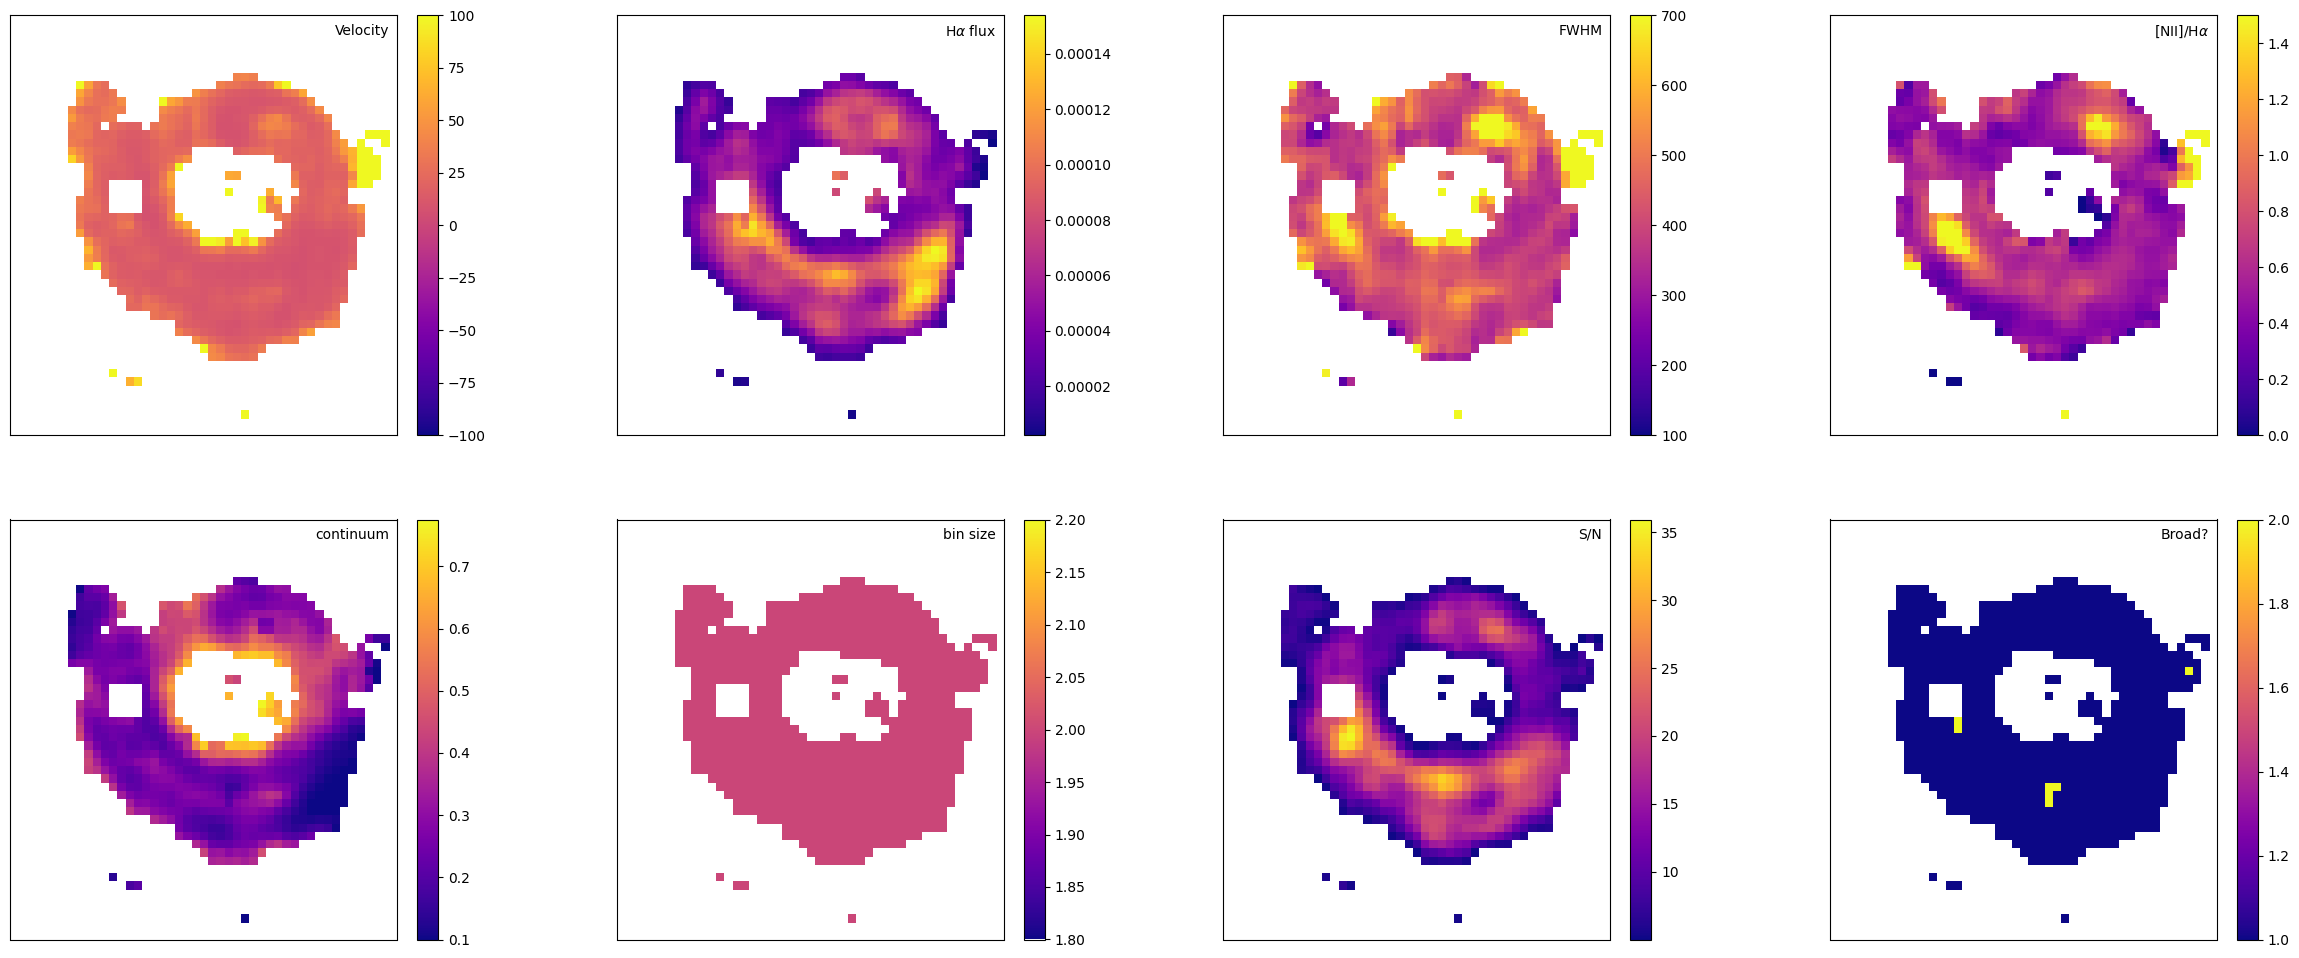

In [17]:
fig = plt.figure(figsize=(30,12))
gs = gridspec.GridSpec(2,4)

# velocity map
ax0 = plt.subplot(gs[0])
im = ax0.imshow(param_cube[0], cmap="plasma", vmin=-100, vmax=100)
plt.colorbar(im, fraction=0.046, pad=0.04)
# H-alpha integrated flux map
ax1 = plt.subplot(gs[1])
im = ax1.imshow(param_cube[1]*norm_map, cmap="plasma")
plt.colorbar(im, fraction=0.046, pad=0.04)
# FWHM map
ax2 = plt.subplot(gs[2])
im = ax2.imshow(param_cube[2]*2.35, cmap="plasma", vmin=100, vmax=700)
plt.colorbar(im, fraction=0.046, pad=0.04)
# [NII]/H-alpha map
ax3 = plt.subplot(gs[3])
im = ax3.imshow(param_cube[3], cmap="plasma", vmin=0, vmax=1.5)
plt.colorbar(im, fraction=0.046, pad=0.04)
# continuum map
ax4 = plt.subplot(gs[4])
im = ax4.imshow(param_cube[4], cmap="plasma")
plt.colorbar(im, fraction=0.046, pad=0.04)
# bin size map
ax5 = plt.subplot(gs[5])
im = ax5.imshow(bin_map, cmap="plasma")
plt.colorbar(im, fraction=0.046, pad=0.04)
# S/N map
ax6 = plt.subplot(gs[6])
im = ax6.imshow(snr_map, cmap="plasma")
plt.colorbar(im, fraction=0.046, pad=0.04)
# broad map
ax7 = plt.subplot(gs[7])
im = ax7.imshow(broad_map, cmap="plasma")
plt.colorbar(im, fraction=0.046, pad=0.04)

labels = ["Velocity", r"H$\alpha$ flux", "FWHM", r"[NII]/H$\alpha$",
          "continuum", "bin size", "S/N", "Broad?"]
for i, ax in enumerate([ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7]):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0.98, 0.98, labels[i], ha="right", va="top", transform=ax.transAxes, c="k")

plt.show()